In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import matplotlib.pyplot as plt

### Black-Scholes Pricing Model Class

This class implements a Black-Scholes pricing model for European options, providing both analytical solutions and advanced Monte Carlo techniques to estimate option prices and sensitivities (Greeks).

#### Attributes:
- **S0**: Initial stock price.
- **K**: Strike price of the option.
- **T**: Time to maturity (in years).
- **sigma**: Volatility of the underlying asset.
- **r**: Risk-free interest rate.
- **option_type**: Type of the option, either "call" or "put".
- **sample_size**: *(Optional)* Number of Monte Carlo simulations (default is 10,000).
- **confidence_level**: *(Optional)* Confidence level for error estimation (default is 0.95).
- **epsilon**: *(Optional)* Small perturbation value for numerical methods (default is 1e-2).

#### Methods:
- **`d1()`**: Computes the $d_1$ term in the Black-Scholes formula.
- **`d2()`**: Computes the $d_2$ term in the Black-Scholes formula.
- **`Black_Sholes_Price()`**: Calculates the theoretical price of the option using the Black-Scholes formula.
- **`Black_Sholes_Delta()`**: Calculates the option's delta using the Black-Scholes formula:
  - For calls: $\Delta = N(d_1)$.
  - For puts: $\Delta = -N(-d_1)$.
- **`Black_Sholes_Gamma()`**: Calculates gamma using the formula:

  $$
  \Gamma = \frac{N'(d_1)}{S_0 \cdot \sigma \cdot \sqrt{T}}
  $$
  

#### Monte Carlo Pricing Methods:
- **`Antithetic_Monte_Carlo_Price()`**: Reduces variance by generating two sets of simulated terminal prices: $S_T$ using random numbers $G$ and $-G$.
- **`Importance_Sampling_Monte_Carlo_Price()`**: Improves efficiency by adjusting the sampling distribution to focus on more relevant scenarios (e.g., prices closer to the strike).
- **`Put_Call_Parity_Price()`**: Uses the put-call parity relationship to estimate prices:
  $$
  C - P = S_0 - K e^{-rT}
  $$

#### Greek Estimation Methods:
1. **Finite-Difference (Bump) Methods**:
   - **`Bump_Delta()`**: Perturbs $S_0$ by a small value $h$ and estimates delta:
     $$
     \Delta \approx \frac{V(S_0 + h) - V(S_0 - h)}{2h}
     $$
   - **`Bump_Gamma()`**: Uses central differences to estimate gamma:
     $$
     \Gamma \approx \frac{V(S_0 + h) - 2V(S_0) + V(S_0 - h)}{h^2}
     $$

2. **Pathwise Methods**:
   - **`Pathwise_Delta()`**: Computes delta analytically by differentiating the payoff function under Monte Carlo simulation.
     - Only valid if the derivative and expectation operators can be swapped.

3. **Likelihood Ratio Methods**:
   - **`Likelihood_Delta()`**: Uses the likelihood ratio technique to estimate delta by incorporating the PDF of the underlying distribution.
   - **`Likelihood_Gamma()`**: Extends the likelihood ratio approach to compute gamma, even when the payoff function is non-differentiable.

4. **Hybrid Methods**:
   - **`Pathwise_Likelihood_Gamma()`**: A combination of pathwise and likelihood methods for gamma estimation.
   - **`Likelihood_Pathwise_Gamma()`**: An alternative hybrid approach for estimating gamma.

#### Notes:
- **Black-Scholes Assumptions**:
  - Constant volatility.
  - Log-normal price distribution.
  - No transaction costs or dividends.

- **Monte Carlo Variance Reduction**:
  - Techniques such as **Antithetic Variates** and **Importance Sampling** improve accuracy and efficiency of simulations.

- **Greeks**:
  - Delta, Gamma, and Vega measure the sensitivities of the option price to changes in the underlying parameters:
    - Delta: Sensitivity to the underlying asset price.
    - Gamma: Sensitivity of delta to the underlying asset price.
    - Vega: Sensitivity to volatility.
  - **Pathwise and Likelihood Ratio Methods**:
    - Provide more efficient and accurate estimations of Greeks, especially for higher-order sensitivities like gamma.
    - Likelihood ratio methods are more robust for non-differentiable payoff functions.

In [3]:
class European_Option:
    def __init__(self, S0, K, T, sigma, r, option_type, sample_size = 10000, confidence_level = 0.95, epsilon = 1e-2):
        self.S0 = S0
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.option_type = option_type
        self.sample_size = sample_size
        self.confidence_level = confidence_level
        self.epsilon = epsilon

    def d1(self):
        return (np.log(self.S0 / self.K) + (self.r + self.sigma**2 / 2)) * self.T / (self.sigma * np.sqrt(self.T))

    def d2(self):
        return (np.log(self.S0 / self.K) + (self.r - self.sigma**2 / 2)) * self.T / (self.sigma * np.sqrt(self.T))

    def Black_Sholes_Price(self):
        
        if self.option_type == "call":
            price = self.S0 * norm.cdf(self.d1()) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2())

        elif self.option_type == "put":
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2()) - self.S0 * norm.cdf(-self.d1())

        else:
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")
        
        return price  

    def Monte_Carlo_Price(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

    def Antithetic_Monte_Carlo_Price(self):
        G = npr.normal(0, 1, size = (int(self.sample_size / 2), 1))
        ST1 = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)
        ST2 = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * (-G))
        
        if self.option_type == "call":
            payoff = (np.exp(-self.r * self.T) * np.maximum(ST1 - self.K, 0) + np.exp(-self.r * self.T) * np.maximum(ST2 - self.K, 0)) / 2 
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]
            
        elif self.option_type == "put":
            payoff = (np.exp(-self.r * self.T) * np.maximum(self.K - ST1, 0) + np.exp(-self.r * self.T) * np.maximum(self.K - ST2, 0)) / 2 
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

    def Importance_Sampling_Monte_Carlo_Price(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        lam = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T)
        mu = np.log(self.K / lam) / self.sigma
        ST = lam * np.exp(self.sigma * np.sqrt(self.T) * (G + mu))
        
        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0) * np.exp(-mu * G - mu ** 2 / 2)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0) * np.exp(-mu * G - mu ** 2 / 2)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

    def Put_Call_Parity_Price(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)
        parity = self.S0 - self.K * np.exp(-self.r * self.T)

        if self.option_type == "call":
            payoff_put = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0)
            price = np.mean(payoff_put) + parity
            standard_deviation = np.std(payoff_put)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]
            
        elif self.option_type == "put":
            payoff_call = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0)
            price = np.mean(payoff_call) - parity
            standard_deviation = np.std(payoff_call)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

    def Black_Sholes_Delta(self):

        if self.option_type == "call":
            delta = norm.cdf(self.d1())

        elif self.option_type == "put":
            delta = -norm.cdf(-self.d1())

        else:
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")
        
        return delta

    def Black_Sholes_Gamma(self):

        if self.option_type == "call":
            gamma = norm.pdf(self.d1()) / (self.S0 * self.sigma * np.sqrt(self.T))

        elif self.option_type == "put":
            gamma = norm.pdf(self.d1()) / (self.S0 * self.sigma * np.sqrt(self.T))

        else:
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")
        
        return gamma
        
    def Bump_Delta(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        h = self.S0 * self.epsilon
        ST1 = (self.S0 + h) * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)
        ST2 = (self.S0 - h) * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = (np.exp(-self.r * self.T) * np.maximum(ST1 - self.K, 0) - np.exp(-self.r * self.T) * np.maximum(ST2 - self.K, 0)) / (2 * h)
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]
            
        elif self.option_type == "put":
            payoff = (np.exp(-self.r * self.T) * np.maximum(self.K - ST1, 0) - np.exp(-self.r * self.T) * np.maximum(self.K - ST2, 0)) / (2 * h)
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return delta, confidence_interval, error

    def Bump_Gamma(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        h = self.S0 * self.epsilon
        ST0 = (self.S0) * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)
        ST1 = (self.S0 + h) * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)
        ST2 = (self.S0 - h) * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = (np.exp(-self.r * self.T) * np.maximum(ST1 - self.K, 0) - 2 * (np.exp(-self.r * self.T) * np.maximum(ST0 - self.K, 0)) + np.exp(-self.r * self.T) * np.maximum(ST2 - self.K, 0)) / (h ** 2)
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]
            
        elif self.option_type == "put":
            payoff = (np.exp(-self.r * self.T) * np.maximum(self.K - ST1, 0) - 2 * (np.exp(-self.r * self.T) * np.maximum(self.K - ST0, 0)) + np.exp(-self.r * self.T) * np.maximum(self.K - ST2, 0)) / (h ** 2)
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return gamma, confidence_interval, error

    def Pathwise_Delta(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * (ST > self.K) * ST / self.S0
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * (self.K > ST) * (-ST) / self.S0
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return delta, confidence_interval, error

    def Likelihood_Delta(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0) * G / (self.S0 * self.sigma * np.sqrt(self.T))
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0) * G / (self.S0 * self.sigma * np.sqrt(self.T))
            delta = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [delta - error, delta + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return delta, confidence_interval, error

    def Likelihood_Gamma(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0) * (((G**2 - 1) / ((self.S0**2) * (self.sigma**2) * self.T)) - (G / ((self.S0**2) * self.sigma * np.sqrt(self.T))))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0) * (((G**2 - 1) / ((self.S0**2) * (self.sigma**2) * self.T)) - (G / ((self.S0**2) * self.sigma * np.sqrt(self.T))))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return gamma, confidence_interval, error

    def Pathwise_Likelihood_Gamma(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * (ST / (self.S0**2)) * (ST > self.K) * ((G / (self.sigma * np.sqrt(self.T))) - 1)
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * (ST / (self.S0**2)) * (self.K > ST) * (1 - (G / (self.sigma * np.sqrt(self.T))))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return gamma, confidence_interval, error

    def Likelihood_Pathwise_Gamma(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - self.sigma**2 / 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * (self.K / (self.S0**2)) * (ST > self.K) * (G / (self.sigma * np.sqrt(self.T)))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * (-self.K / (self.S0**2)) * (self.K > ST) * (G / (self.sigma * np.sqrt(self.T)))
            gamma = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [gamma - error, gamma + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return gamma, confidence_interval, error

### Example Usage of the European Option Class

This example demonstrates how to use the `European_Option` class to calculate the price of a European call option using both the Black-Scholes formula and a Monte Carlo simulation.

#### Parameters:
- **S0**: Spot price of the underlying asset (\$100).
- **K**: Strike price of the option (\$100).
- **T**: Time to maturity (1 year).
- **sigma**: Volatility of the underlying asset (20%).
- **r**: Risk-free interest rate (5%).
- **option_type**: Option type ("call").

#### Outputs:
1. **Black-Scholes Option Price**:
   - Computed using the closed-form solution of the Black-Scholes formula.
   - Result is printed with five decimal places.

2. **Monte Carlo Option Price**:
   - Estimated using Monte Carlo simulation.
   - Includes:
     - The option price.
     - The confidence interval for the estimate (95% by default).
     - The Monte Carlo simulation error.

In [5]:
european_option = European_Option(
    S0 = 100,               # Spot price of 100
    K = 100,                # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call"    # Option Type
)

bs_price = european_option.Black_Sholes_Price()
print(f"Black-Sholes Option price: {bs_price:.5f}")
print('\n')
mc_price, mc_confidence_interval, mc_error = european_option.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{mc_confidence_interval[0]:.5f}, {mc_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {mc_error:.5f}")

Black-Sholes Option price: 10.45058


Monte Carlo Option Price: 10.60485
95% Confidence Interval: [10.31685, 10.89285]
Monte Carlo Error: 0.28800


### Confidence Interval Validation for Monte Carlo Simulation

This block of code tests whether the confidence intervals generated by the Monte Carlo simulation are consistent with the specified confidence level (95% by default). The procedure uses statistical hypothesis testing with the following steps:

#### Procedure:
1. **Simulation and Proportion Calculation**:
   - Runs the Monte Carlo simulation `n` times (here, $n=100$).
   - Checks how many times the Black-Scholes price falls within the Monte Carlo confidence interval.
   - Calculates the observed proporion $\hat{p}$ of times the Black-Scholes price is within the confidence interval.

2. **Null and Alternative Hypotheses**:
   - $H_0$: The Monte Carlo confidence interval is at the 95% level ($p = 0.95$).
   - $H_1$: The Monte Carlo confidence interval is not at the 95% level ($p \neq 0.95$).

3. **Statistical Testing**:
   - Computes the standard deviation for the observed proportion:
     $$
     \text{Standard Deviation} = \sqrt{\frac{p_0 \cdot (1 - p_0)}{n}}
     $$
     where $p_0$ is the expected confidence level (0.95).
   - Calculates the $Z$-statistic to measure the deviation of $\hat{p}$ from $p_0$:
     $$
     Z = \frac{\hat{p} - p_0}{\text{Standard Deviation}}
     $$
   - Computes the $p$-value for the two-tailed test.

4. **Decision Rule**:
   - If $p$-value < $\alpha$ (default significance level $\alpha = 0.05$), reject the null hypothesis $H_0$.
   - Otherwise, fail to reject $H_0$.

#### Outputs:
- **Observed Proportion ($\hat{p}$)**: The proportion of simulations where the Black-Scholes price lies within the Monte Carlo confidence interval.
- **Z-Statistic**: The test statistic measuring the deviation of $\hat{p}$ from the expected value ($p_0 = 0.95$).
- **P-Value**: The probability of observing a result as extreme as the one obtained, assuming $H_0$ is true.
- **Hypothesis testing decision**: Either reject  $H_0$ or fail to reject $H_0$.

#### Interpretation:
- If the null hypothesis is **rejected**, the Monte Carlo confidence intervals do not align with the 95% confidence level.
- If the null hypothesis is **not rejected**, the Monte Carlo confidence intervals appear consistent with the expected 95% level.

In [7]:
cont = 0
n = 100
for ii in range(1,n + 1):
    mc_price, mc_confidence_interval, mc_error = european_option.Monte_Carlo_Price()
    if(bs_price >= mc_confidence_interval[0] and bs_price <= mc_confidence_interval[1]):
        cont += 1
p0 = european_option.confidence_level
p_hat = cont / n
standard_deviation = (p0 * (1 - p0) / n) ** 0.5
z_statistics = (p_hat - p0) / standard_deviation
p_value = 2 * (1 - norm.cdf(abs(z_statistics)))

print(f"Observed Proportion: {p_hat:.5f}, Z-Statistic: {z_statistics:.5f}, P-Value: {p_value:.5f}")
alpha = 0.05
print("H0: the confidence interval is at 95% level vs H1: the confidence interval is not at 95% level")
if p_value < alpha:
    print("Reject the null hypothesis: the confidence interval is not at the 95% level.")
else:
    print("Fail to reject the null hypothesis: the confidence interval appears to be at the 95% level.")

Observed Proportion: 0.93000, Z-Statistic: -0.91766, P-Value: 0.35880
H0: the confidence interval is at 95% level vs H1: the confidence interval is not at 95% level
Fail to reject the null hypothesis: the confidence interval appears to be at the 95% level.


### Monte Carlo Results Comparison

This block of code compares the option prices and confidence intervals calculated using three advanced Monte Carlo methods: **Antithetic Variates**, **Put-Call Parity**, and **Importance Sampling**.

#### Observations:
- **Antithetic Monte Carlo Method**:
  - Produces the lowest variance among the three methods for an at-the-money (ATM) option.
  - Leverages negatively correlated random variables to consistently reduce variance, which aligns with the theoretical property that antithetic variables always improve efficiency.
  - However, the variance reduction achieved is generally modest compared to other advanced methods.
  - Recommended as the best method for variance reduction in this scenario.

- **Put-Call Parity Method**:
  - Achieves moderate variance reduction for ATM options by utilizing the put-call parity relationship.
  - This method works best for in-the-money (ITM) options, where the parity relationship provides a more stable and accurate representation of the relationship between call and put prices.
  - Variance reduction depends on the parity relationship's accuracy, which can vary based on the payoff distribution.
  - While not as effective as the antithetic method in this scenario, it can provide meaningful variance reduction for ITM options.

- **Importance Sampling Method**:
  - Increases variance for ATM options instead of reducing it, which aligns with the theoretical understanding that importance sampling performs poorly if the shifted distribution is not suitable for the given scenario.
  - For ATM options, the choice of the shifted distribution (based on $\mu$) leads to poor alignment with the relevant payoff distribution, causing higher variability.
  - This method works best for out-of-the-money (OTM) options, where the shifted distribution can better capture rare but important payoffs.
  - It is the least effective here and can be counterproductive for variance reduction when applied inappropriately.

#### Theoretical Alignment:
- **Antithetic Variates**:
  - Always work to reduce variance, though the reduction is often modest compared to other methods.
- **Put-Call Parity**:
  - Works best for ITM options, where the parity relationship ensures greater stability and accuracy.
- **Importance Sampling**:
  - Highly effective for OTM options, where shifting the distribution appropriately aligns with the rare but relevant payoff scenarios.

#### Key Takeaways:
- For ATM options, the **Antithetic Variates** method is the most efficient and reliable for reducing variance in Monte Carlo simulations.
- The **Put-Call Parity Method** is a good choice for ITM options, where it can provide significant variance reduction by leveraging the stability of the parity relationship.
- The **Importance Sampling Method** is most suitable for OTM options, where it aligns with the payoff distribution and significantly reduces variance. However, it is not effective for ATM options and can increase variance when applied inappropriately.

In [9]:
antithetic_mc_price, antithetic_mc_confidence_interval, antithetic_mc_error = european_option.Antithetic_Monte_Carlo_Price()
print(f"Antithetic Monte Carlo Option Price: {antithetic_mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Antithetic Confidence Interval: [{antithetic_mc_confidence_interval[0]:.5f}, {antithetic_mc_confidence_interval[1]:.5f}]")
print(f"Antithetic Monte Carlo Error: {antithetic_mc_error:.5f}")
print('\n')
call_parity_price, parity_confidence_interval, parity_error = european_option.Put_Call_Parity_Price()
print(f"Put-Call Parity Option Price: {call_parity_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{parity_confidence_interval[0]:.5f}, {parity_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {parity_error:.5f}")
print('\n')
importance_sampling_mc_price, importance_sampling_mc_confidence_interval, importance_sampling_mc_error = european_option.Importance_Sampling_Monte_Carlo_Price()
print(f"Importance Sampling Monte Carlo Option Price: {importance_sampling_mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Importance Sampling Confidence Interval: [{importance_sampling_mc_confidence_interval[0]:.5f}, {importance_sampling_mc_confidence_interval[1]:.5f}]")
print(f"Importance Sampling Monte Carlo Error: {importance_sampling_mc_error:.5f}")

Antithetic Monte Carlo Option Price: 10.35203
95% Antithetic Confidence Interval: [10.20965, 10.49441]
Antithetic Monte Carlo Error: 0.14238


Put-Call Parity Option Price: 10.37431
95% Confidence Interval: [10.20473, 10.54389]
Monte Carlo Error: 0.16958


Importance Sampling Monte Carlo Option Price: 10.40328
95% Importance Sampling Confidence Interval: [10.05284, 10.75372]
Importance Sampling Monte Carlo Error: 0.35044


### Monte Carlo Methods Comparison for In-the-Money (ITM) Option

This block of code evaluates the pricing and variance reduction performance of various Monte Carlo methods for an in-the-money (ITM) option scenario. The results demonstrate how different methods perform when the option parameters favor specific approaches.

#### Observations:
- **Black-Scholes Formula**:
  - Provides the benchmark price for the ITM option, which other methods aim to approximate.

- **Standard Monte Carlo Method**:
  - Produces a reasonably accurate estimate of the option price with a standard confidence interval and error margin.
  - Serves as the baseline for comparing variance reduction methods.

- **Put-Call Parity Method**:
  - As expected for ITM options, this method outperforms all others in terms of variance reduction and accuracy.
  - The stability of the put-call parity relationship ensures a significant reduction in variance for ITM options, making this the best method for this scenario.

- **Antithetic Monte Carlo Method**:
  - Continues to provide reliable variance reduction, as it always improves efficiency regardless of the scenario.
  - However, the variance reduction is less significant compared to the put-call parity method in this ITM case, leading to slightly worse results.

- **Importance Sampling Method**:
  - Dramatically increases the variance of the estimates, leading to poor results once again.
  - This behavior aligns with theoretical expectations, as importance sampling is unsuitable for ITM options. The shifted sampling distribution used by this method is misaligned with the payoff distribution in ITM scenarios, causing instability and higher variability.

#### Theoretical Alignment:
- **Put-Call Parity Method**:
  - Works exceptionally well for ITM options due to the stability of the parity relationship. It is the most effective variance reduction method in this case.
- **Antithetic Variates**:
  - Always reduce variance but do not achieve the same level of reduction as the put-call parity method for ITM options.
- **Importance Sampling**:
  - Highly unsuitable for ITM options, as the sampling distribution is poorly aligned with the payoff distribution. This leads to an increase in variance, making it the least effective method.

#### Key Takeaways:
- For ITM options, the **Put-Call Parity Method** is the best variance reduction approach, providing both accuracy and stability.
- The **Antithetic Monte Carlo Method** remains reliable but performs worse than the put-call parity method in this case.
- The **Importance Sampling Method** is highly inefficient for ITM options, significantly increasing variance and yielding the worst results.

In [11]:
european_option_itm = European_Option(
    S0 = 200,               # Spot price of 100
    K = 100,                # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call"    # Option Type
)

print(f"Black-Sholes Option price: {european_option_itm.Black_Sholes_Price():.5f}")
print('\n')
mc_price, mc_confidence_interval, mc_error = european_option_itm.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{mc_confidence_interval[0]:.5f}, {mc_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {mc_error:.5f}")
print('\n')
antithetic_mc_price, antithetic_mc_confidence_interval, antithetic_mc_error = european_option_itm.Antithetic_Monte_Carlo_Price()
print(f"Antithetic Monte Carlo Option Price: {antithetic_mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Antithetic Confidence Interval: [{antithetic_mc_confidence_interval[0]:.5f}, {antithetic_mc_confidence_interval[1]:.5f}]")
print(f"Antithetic Monte Carlo Error: {antithetic_mc_error:.5f}")
print('\n')
call_parity_price, parity_confidence_interval, parity_error = european_option_itm.Put_Call_Parity_Price()
print(f"Put-Call Parity Option Price: {call_parity_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{parity_confidence_interval[0]:.5f}, {parity_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {parity_error:.5f}")
print('\n')
importance_sampling_mc_price, importance_sampling_mc_confidence_interval, importance_sampling_mc_error = european_option_itm.Importance_Sampling_Monte_Carlo_Price()
print(f"Importance Sampling Monte Carlo Option Price: {importance_sampling_mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Importance Sampling Confidence Interval: [{importance_sampling_mc_confidence_interval[0]:.5f}, {importance_sampling_mc_confidence_interval[1]:.5f}]")
print(f"Importance Sampling Monte Carlo Error: {importance_sampling_mc_error:.5f}")

Black-Sholes Option price: 104.87772


Monte Carlo Option Price: 105.03366
95% Confidence Interval: [104.22924, 105.83807]
Monte Carlo Error: 0.80442


Antithetic Monte Carlo Option Price: 104.80567
95% Antithetic Confidence Interval: [104.69864, 104.91271]
Antithetic Monte Carlo Error: 0.10703


Put-Call Parity Option Price: 104.87706
95% Confidence Interval: [104.87706, 104.87706]
Monte Carlo Error: 0.00000


Importance Sampling Monte Carlo Option Price: 51.19461
95% Importance Sampling Confidence Interval: [16.03521, 86.35402]
Importance Sampling Monte Carlo Error: 35.15941


### Monte Carlo Methods Comparison for Out-of-the-Money (OTM) Option

This block of code evaluates the pricing and variance reduction performance of various Monte Carlo methods for an out-of-the-money (OTM) option scenario. The results highlight how the effectiveness of each method changes based on the option parameters.

#### Observations:
- **Black-Scholes Formula**:
  - Provides the benchmark price for the OTM option, which other methods aim to approximate.

- **Standard Monte Carlo Method**:
  - Produces a baseline estimate of the option price with moderate variance.

- **Importance Sampling Method**:
  - As expected, this method performs exceptionally well for OTM options, significantly reducing the variance of the estimator.
  - By shifting the sampling distribution to focus on rare but relevant payoffs, importance sampling achieves greater accuracy and smaller error margins.
  - This is the most effective variance reduction method in this scenario.

- **Antithetic Monte Carlo Method**:
  - Continues to provide moderate variance reduction as before. While reliable, it does not perform as well as importance sampling for OTM options, since the variance reduction achieved is not specifically tailored to rare events.

- **Put-Call Parity Method**:
  - Increases variance in this case, as the parity relationship is less stable for OTM options due to the lower likelihood of meaningful payoffs.
  - The misalignment between the parity relationship and the OTM payoff distribution leads to poor results, making this the least effective method in this scenario.

#### Theoretical Alignment:
- **Importance Sampling**:
  - Designed to handle scenarios with rare events, such as OTM options, by focusing on the most relevant parts of the distribution. This makes it the best method for variance reduction in this case.
- **Antithetic Variates**:
  - Always reduces variance, but the reduction is less significant for OTM options compared to importance sampling.
- **Put-Call Parity**:
  - Works poorly for OTM options, where the parity relationship does not align well with the payoff structure, leading to increased variance.

#### Key Takeaways:
- For OTM options, the **Importance Sampling Method** is the most effective, significantly reducing variance by focusing on relevant rare events.
- The **Antithetic Monte Carlo Method** provides moderate and consistent variance reduction, as expected, but is less effective than importance sampling in this case.
- The **Put-Call Parity Method** is unsuitable for OTM options, as it increases variance due to the instability of the paity relationship in this context.


In [13]:
european_option_otm = European_Option(
    S0 = 100,               # Spot price of 100
    K = 200,                # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call"    # Option Type
)

print(f"Black-Sholes Option price: {european_option_otm.Black_Sholes_Price():.5f}")
print('\n')
mc_price, mc_confidence_interval, mc_error = european_option_otm.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{mc_confidence_interval[0]:.5f}, {mc_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {mc_error:.5f}")
print('\n')
antithetic_mc_price, antithetic_mc_confidence_interval, antithetic_mc_error = european_option_otm.Antithetic_Monte_Carlo_Price()
print(f"Antithetic Monte Carlo Option Price: {antithetic_mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Antithetic Confidence Interval: [{antithetic_mc_confidence_interval[0]:.5f}, {antithetic_mc_confidence_interval[1]:.5f}]")
print(f"Antithetic Monte Carlo Error: {antithetic_mc_error:.5f}")
print('\n')
call_parity_price, parity_confidence_interval, parity_error = european_option_otm.Put_Call_Parity_Price()
print(f"Put-Call Parity Option Price: {call_parity_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{parity_confidence_interval[0]:.5f}, {parity_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {parity_error:.5f}")
print('\n')
importance_sampling_mc_price, importance_sampling_mc_confidence_interval, importance_sampling_mc_error = european_option_otm.Importance_Sampling_Monte_Carlo_Price()
print(f"Importance Sampling Monte Carlo Option Price: {importance_sampling_mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Importance Sampling Confidence Interval: [{importance_sampling_mc_confidence_interval[0]:.5f}, {importance_sampling_mc_confidence_interval[1]:.5f}]")
print(f"Importance Sampling Monte Carlo Error: {importance_sampling_mc_error:.5f}")

Black-Sholes Option price: 0.00480


Monte Carlo Option Price: 0.00276
95% Confidence Interval: [-0.00107, 0.00659]
Monte Carlo Error: 0.00383


Antithetic Monte Carlo Option Price: 0.00148
95% Antithetic Confidence Interval: [0.00005, 0.00291]
Antithetic Monte Carlo Error: 0.00143


Put-Call Parity Option Price: 0.00784
95% Confidence Interval: [-0.38440, 0.40007]
Monte Carlo Error: 0.39224


Importance Sampling Monte Carlo Option Price: 0.00485
95% Importance Sampling Confidence Interval: [0.00472, 0.00498]
Importance Sampling Monte Carlo Error: 0.00013


### Understanding the Basic Idea Behind Importance Sampling

This code illustrates the fundamental concept of the **Importance Sampling** method by comparing the number of paths where $S_T > K$ (i.e., the terminal price exceeds the strike price) under standard Monte Carlo sampling and importance sampling.

#### Explanation:
- **Standard Monte Carlo Sampling**:
  - The terminal prices $S_T$ are generated using the original distribution of the underlying asset:
    $$
    S_T = S_0 \cdot \exp\left((r - \frac{\sigma^2}{2}) T + \sigma \sqrt{T} G\right)
    $$
  - For an out-of-the-money (OTM) option, the likelihood of $S_T > K$ is very low, as the strike price is significantly higher than the initial price. Consequently, the number of paths satisfying $S_T > K$ is small, leading to higher variance in the payoff estimation.

- **Importance Sampling**:
  - Shifts the distribution of $S_T$ by adjusting the mean of the random variables (using $ \mu $):
    $$
    \mu = \frac{\log\left(\frac{K}{\lambda}\right)}{\sigma}, \quad \lambda = S_0 \cdot \exp\left((r - \frac{\sigma^2}{2}) T\right)
    $$
    $$
    S_T = \lambda \cdot \exp\left(\sigma \sqrt{T} (G + \mu)\right)
    $$
  - This shift increases the likelihood of $S_T > K$, resulting in a larger number of paths satisfying this condition.
  - The increase in relevant paths reduces the variance of the estimator because the rare but significant evets (payoffs) are bet


In [15]:
G = npr.normal(0, 1, size = (european_option_otm.sample_size, 1))
ST = european_option_otm.S0 * np.exp((european_option_otm.r - european_option_otm.sigma**2 / 2) * european_option_otm.T + european_option_otm.sigma * np.sqrt(european_option_otm.T) * G)
path_number_standard_mc = sum(ST > european_option_otm.K)
print(f"Number of paths such that ST is bigger than K: {path_number_standard_mc[0]}")
lam = european_option_otm.S0 * np.exp((european_option_otm.r - european_option_otm.sigma**2 / 2) * european_option_otm.T)
mu = np.log(european_option_otm.K / lam) / european_option_otm.sigma
ST = lam * np.exp(european_option_otm.sigma * np.sqrt(european_option_otm.T) * (G + mu))
path_number_importance_sampling = sum(ST > european_option_otm.K)
print(f"Number of paths such that ST is bigger than K: {path_number_importance_sampling[0]}")

Number of paths such that ST is bigger than K: 6
Number of paths such that ST is bigger than K: 5006


### Convergence of the Monte Carlo Method

This graph demonstrates the convergence behavior of the Monte Carlo (MC) method for pricing a European call option as the sample size ($N$) increases. The analysis compares the error between the Monte Carlo price and the Black-Scholes price with the theoretical convergence rate of $\frac{1}{\sqrt{N}}$.

#### Explanation:
- **Monte Carlo Error (Blue Line)**:
  - Represents the actual error in the MC price as a function of the sample size.
  - As $N$ increases, the MC error decreases, showing the expected convergence behavior.
  
- **Theoretical Error (Red Dashed Line)**:
  - Represents the theoretical rate of error decay for the Monte Carlo method, which is proportional to $\frac{1}{\sqrt{N}}$.
  - This theoretical line serves as a benchmark for the convergence rate.

#### Observations:
- The Monte Carlo error closely follows the theoretical $\frac{1}{\sqrt{N}}$ line, especially for large sample sizes, validating the convergence behavior of the method.

#### Key Takeaways:
- The Monte Carlo method converges at the expected rate of $\frac{1}{\sqrt{N}}$, confirming its theoretical foundation.
- Increasing the sample size significantly reduces the error, but the rate of improvement slows down due to the $\frac{1}{\sqrt{N}}$ dependence, highlighting the diminishing returns of adding more samples.

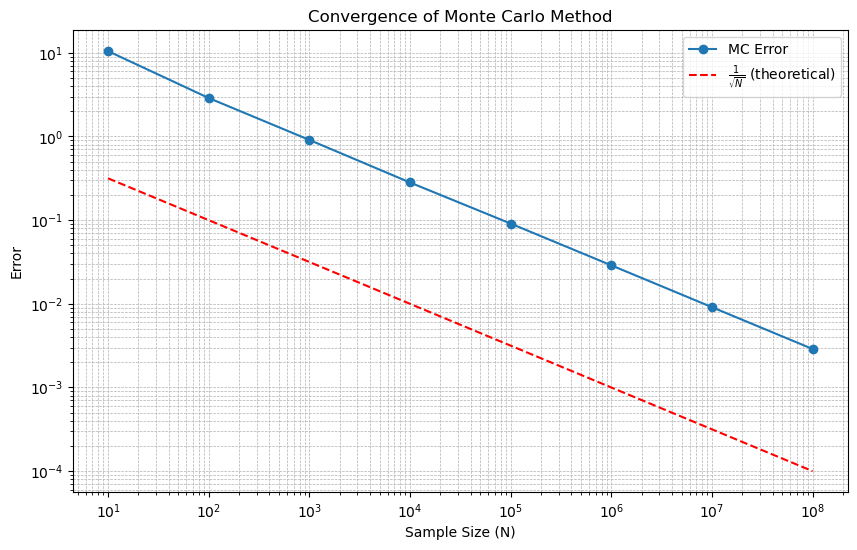

In [17]:
N = []
error = []
for ii in range(1, 9):
    option_test = European_Option(
    S0 = 100,               # Spot price of 100
    K = 100,                # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call",   # Option Type
    sample_size = 10**ii    # Sample Size
    )
    bs_price = option_test.Black_Sholes_Price()
    mc_price, _, difference = option_test.Monte_Carlo_Price()
    N.append(10**ii)
    error.append(difference)

theoretical_error = [1 / np.sqrt(n) for n in N]
plt.figure(figsize = (10, 6))
plt.loglog(N, error, marker = 'o', label = "MC Error")
plt.loglog(N, theoretical_error, linestyle = '--', color = 'red', label = r"$\frac{1}{\sqrt{N}}$ (theoretical)")
plt.xlabel("Sample Size (N)")
plt.ylabel("Error")
plt.title("Convergence of Monte Carlo Method")
plt.grid(True, which = "both", linestyle = "--", linewidth = 0.5)
plt.legend()
plt.show()

### Estimating Option Greeks Using the Bump Method

This block of code demonstrates the estimation of **Delta** and **Gamma** for a European option using both the **Black-Scholes closed-form solution** and the **Monte Carlo bump method**.

#### Explanation of the Bump Method:
The bump method is a finite-difference approach used to numerically estimate sensitivities (Greeks) by perturbing the underlying asset price. For Delta and Gamma:

- **Delta ($\Delta$)**:
  - Delta measures the sensitivity of the option price to changes in the underlying asset price $S_0$.
  - The bump method perturbs $S_0$ by a small amount $h$ (proportional to $S_0 \cdot \epsilon$) and calculates the difference in the option prices for $(S_0 + h)$ and $(S_0 - h)$:
    $$
    \Delta \approx \frac{V(S_0 + h) - V(S_0 - h)}{2h}
    $$
  - The Monte Carlo simulation computes the discounted payoff for the perturbed prices and averages the results.

- **Gamma ($\Gamma$)**:
  - Gamma measures the sensitivity of Delta to changes in the underlying asset price $S_0$.
  - The bump method uses central differences to calculate the change in Delta for $(S_0 + h)$, $S_0$, and $(S_0 - h)$:
    $$
    \Gamma \approx \frac{V(S_0 + h) - 2V(S_0) + V(S_0 - h)}{h^2}
    $$
  - Like Delta, the Monte Carlo simulation computes the discounted payoff for the three perturbed prices.

#### Outputs:
1. **Black-Scholes Delta**:
   - Delta calculated using the closed-form Black-Scholes formula for comparison.
   - Formula: $\Delta = N(d_1)$ for a call option and $\Delta = -N(-d_1)$ for a put option.

2. **Monte Carlo Bump Delta**:
   - Delta estimated using the bump method via Monte Carlo simulation.
   - Includes:
     - Estimated Delta.
     - Confidence interval for the estimate.
     - Monte Carlo error.

3. **Black-Scholes Gamma**:
   - Gamma calculated using the closed-form Black-Scholes formula for comparison.
   - Formula: $\Gamma = \frac{N'(d_1)}{S_0 \cdot \sigma \cdot \sqrt{T}}$, where $N'(d_1)$ is the probability density function (PDF) of the standard normal distribution.

4. **Monte Carlo Bump Gamma**:
   - Gamma estimated using the bump method via Monte Carlo simulation.
   - Includes:
     - Estimated Gamma.
     - Confidence interval for the estimate.
     - Monte Carlo error.

#### Observations:
- The bump method provides an intuitive and straightforward way to estimate Greeks numerically.
- The accuracy of the bump method depends on the choice of $h$:
  - If $h$ is too large, the approximation deviates from the true derivative.
  - If $h$ is too small, numerical errors can accumulate.

#### Key Takeaways:
- The Monte Carlo bump method is versatile and can estimate Greeks without requiring closed-form solutions.
- While computationally expensive, the bump method is useful when closed-form formulas for Greeks are unavailable.
- The confidence interval and Monte Carlo errorprovide a measure of the reliability of the estimates.


In [19]:
print(f"Black-Sholes Option Delta: {european_option.Black_Sholes_Delta():.5f}")
bump_delta, bump_delta_confidence_interval, bump_delta_error = european_option.Bump_Delta()
print(f"Monte Carlo Option Bump Delta: {bump_delta:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{bump_delta_confidence_interval[0]:.5f}, {bump_delta_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {bump_delta_error:.5f}")
print('\n')
print(f"Black-Sholes Option Gamma: {european_option.Black_Sholes_Gamma():.5f}")
bump_gamma, bump_gamma_confidence_interval, bump_gamma_error = european_option.Bump_Gamma()
print(f"Monte Carlo Option Bump Gamma: {bump_gamma:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{bump_gamma_confidence_interval[0]:.5f}, {bump_gamma_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {bump_gamma_error:.5f}")

Black-Sholes Option Delta: 0.63683
Monte Carlo Option Bump Delta: 0.64205
95% Confidence Interval: [0.63088, 0.65322]
Monte Carlo Error: 0.01117


Black-Sholes Option Gamma: 0.01876
Monte Carlo Option Bump Gamma: 0.02015
95% Confidence Interval: [0.01796, 0.02233]
Monte Carlo Error: 0.00218


### Estimating Delta Using the Pathwise Method

This block of code demonstrates the estimation of **Delta** for a European option using the **Black-Scholes closed-form solution** and the **Monte Carlo pathwise method**.

#### Explanation of the Pathwise Method:
The pathwise method, also known as the **direct differentiation method**, calculates Delta by differentiating the payoff function with respect to the underlying asset price $S_0$. Unlike the bump method, the pathwise method computes the derivative analytically, avoiding the need for numerical perturbations.

For Delta:
- Delta measures the sensitivity of the option price to changes in $S_0$:
  $$
  \Delta = \frac{\partial V(S_0)}{\partial S_0}
  $$
- The pathwise method is based on **inverting the derivative and expectation operators**, allowing the differentiation to act on the payoff function:
  $$
  \Delta = \mathbb{E}\left[\frac{\partial \text{Payoff}}{\partial S_0}\right]
  $$
- For a **call option**, the derivative of the payoff is:
  $$
  \Delta = \mathbb{E}\left[e^{-rT} \cdot \mathbb{1}(S_T > K) \cdot \frac{S_T}{S_0}\right]
  $$
  where:
  - $\mathbb{1}(S_T > K)$ is an indicator function that equals 1 if $S_T > K$ (the option expires in the money) and 0 otherwise.
  - $S_T$ is the terminal price of the underlying asset.
- For a **put option**, the derivative is:
  $$
  \Delta = \mathbb{E}\left[e^{-rT} \cdot \mathbb{1}(S_T < K) \cdot \frac{-S_T}{S_0}\right]
  $$
- The Monte Carlo simulation evaluates this expectation by simulating multiple paths of $S_T$ and averaging the results.

#### Limitations of the Pathwise Method:
- The key assumption is that the **derivative and expectation operators can be inverted**, which is not always valid.
- For example, the Gamma cannot be computed using such method

#### Advantages of the Pathwise Method:
- **No Numerical Perturbation**: Unlike the bump method, the pathwise method uses an analytical expression for the derivative, avoiding issues with choosing a perturbation size $h$.
- **Efficient for Delta**: The method works particularly well for Delta because the derivative of the payoff is straightforward to compute.

#### Outputs:
1. **Black-Scholes Delta**:
   - Delta calculated using the closed-form Black-Scholes formula for comparison.
   - Formula: $\Delta = N(d_1)$ for a call option and $\Delta = -N(-d_1)$ for a put option.

2. **Monte Carlo Pathwise Delta**:
   - Delta estimated using the pathwise method via Monte Carlo simulation.
   - Includes:
     - Estimated Delta.
     - Confidence interval for the estimate.
     - Monte Carlo error.

#### Observations:
- The pathwise method provides a more efficient and precise way to compute Delta compared to the bump method, as it avoids the need for multiple perturbed simulations.
- However, this method cannot be extended to all Greeks (e.g., Gamma) due to the non-differentiability of the payoff function.

#### Key Takeaways:
- The pathwise method is ideal for estimating Delta when the payoff function is differentiable with respect to $S_0$ and the derivative and expectation can be inverted.
- It is computationally more efficient and less prone to numerical errors than the bump method.
- Confidence intervals and Monte Carlo errors provide a measure of reliability for the Delta estimate.

In [21]:
print(f"Black-Sholes Option Delta: {european_option.Black_Sholes_Delta():.5f}")
pathwise_delta, pathwise_delta_confidence_interval, pathwise_delta_error = european_option.Pathwise_Delta()
print(f"Monte Carlo Option Pathwise Delta: {pathwise_delta:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{pathwise_delta_confidence_interval[0]:.5f}, {pathwise_delta_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {pathwise_delta_error:.5f}")

Black-Sholes Option Delta: 0.63683
Monte Carlo Option Pathwise Delta: 0.63784
95% Confidence Interval: [0.62657, 0.64912]
Monte Carlo Error: 0.01127


### Estimating Delta and Gamma Using the Likelihood Ratio Method

This block of code demonstrates the estimation of **Delta** and **Gamma** for a European option using the **Black-Scholes closed-form solution** and the **Monte Carlo likelihood ratio method**.

#### Explanation of the Likelihood Ratio Method:
The likelihood ratio method, like the pathwise method, is based on **inverting the derivative and expectation operators**. However, it is more flexible because it works with the probability density function (PDF) of the underlying distribution rather than the payoff function. Since PDFs are typically more regular (smooth) than payoff functions, this method can handle Greeks like Gamma, which cannot be computed directly using the pathwise method.

For Delta:
- Delta measures the sensitivity of the option price to changes in $S_0$.
- The likelihood ratio method incorporates the derivative of the PDF into the expectation:
  $$
  \Delta = \mathbb{E}\left[e^{-rT} \cdot \text{Payoff} \cdot \frac{\partial \log f(S_T)}{\partial S_0}\right]
  $$
- For a **call option**, this translates to:
  $$
  \Delta = \mathbb{E}\left[e^{-rT} \cdot \max(S_T - K, 0) \cdot \frac{G}{S_0 \cdot \sigma \cdot \sqrt{T}}\right]
  $$
  where $G$ is the standard normal random variable used to simulate $S_T$.

For Gamma:
- Gamma measures the sensitivity of Delta to changes in $S_0$.
- Using the likelihood ratio method, Gamma incorporates higher-order derivatives of the PDF:
  $$
  \Gamma = \mathbb{E}\left[e^{-rT} \cdot \text{Payoff} \cdot \left(\frac{G^2 - 1}{S_0^2 \cdot \sigma^2 \cdot T} - \frac{G}{S_0^2 \cdot \sigma \cdot \sqrt{T}}\right)\right]
  $$
- This expression enables the computation of Gamma without requiring the payoff function to be differentiable, unlike the pathwise method.

#### Advantages of the Likelihood Ratio Method:
- **Robust for Any Payoff**: A key advantage of this method is that the formulation is independent of the payoff. The weights (e.g., $\frac{G}{S_0 \cdot \sigma \cdot \sqrt{T}}$ for Delta and $\left(\frac{G^2 - 1}{S_0^2 \cdot \sigma^2 \cdot T} - \frac{G}{S_0^2 \cdot \sigma \cdot \sqrt{T}}\right)$ for Gamma) remain constant regardless of the payoff function.
- **More General**: By working with the density function, this method avoids the limitations of the pathwise method, which requires the payoff function to be differentiable.
- **Applicable to Gamma**: Since PDFs are smooth, the likelihood ratio method can compute higher-order Greeks like Gamma, which cannot be directly computed using the pathwise method.
- **Flexibility**: It is well-suited for complex options where the payoff function may have discontinuities.

#### Outputs:
1. **Black-Scholes Delta**:
   - Delta calculated using the closed-form Black-Scholes formula for comparison.
   - Formula: $\Delta = N(d_1)$ for a call option and $\Delta = -N(-d_1)$ for a put option.

2. **Monte Carlo Likelihood Delta**:
   - Delta estimated using the likelihood ratio method via Monte Carlo simulation.
   - Includes:
     - Estimated Delta.
     - Confidence interval for the estimate.
     - Monte Carlo error.

3. **Black-Scholes Gamma**:
   - Gamma calculated using the closed-form Black-Scholes formula for comparison.
   - Formula: $\Gamma = \frac{N'(d_1)}{S_0 \cdot \sigma \cdot \sqrt{T}}$, where $N'(d_1)$ is the PDF of the standard normal distribution.

4. **Monte Carlo Likelihood Gamma**:
   - Gamma estimated using the likelihood ratio method via Monte Carlo simulation.
   - Includes:
     - Estimated Gamma.
     - Confidence interval for the estimate.
     - Monte Carlo error.

#### Observations:
- The likelihood ratio method provides a more flexible approach for computing Greeks, especially Gamma, compared to the pathwise method.
- Since it uses the PDF rather than the payoff function, it can handle Greeks for which the payoff function is non-differentiable (e.g., Gamma).

#### Key Takeaways:
- The likelihood ratio method generalizes the idea of inverting the derivative and expectation operators, leveraging the smoothness of the PDF.
- It is a powerful tool for estimating higher-order Greeks like Gamma, which are not accessible through the pathwise method.
- Confidence intervals and Monte Carlo errors provide a measure of reliability for the Delta and Gamma estimates.
- The independence of the weights from the payoff ensures that this method is robust and versatile across various options and payoff structures.

In [23]:
print(f"Black-Sholes Option Delta: {european_option.Black_Sholes_Delta():.5f}")
likelihood_delta, likelihood_delta_confidence_interval, likelihood_delta_error = european_option.Likelihood_Delta()
print(f"Monte Carlo Option Likelihood Delta: {likelihood_delta:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{likelihood_delta_confidence_interval[0]:.5f}, {likelihood_delta_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {likelihood_delta_error:.5f}")
print('\n')
print(f"Black-Sholes Option Gamma: {european_option.Black_Sholes_Gamma():.5f}")
likelihood_gamma, likelihood_gamma_confidence_interval, likelihood_gamma_error = european_option.Likelihood_Gamma()
print(f"Monte Carlo Option Likelihood Gamma: {likelihood_gamma:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{likelihood_gamma_confidence_interval[0]:.5f}, {likelihood_gamma_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {likelihood_gamma_error:.5f}")

Black-Sholes Option Delta: 0.63683
Monte Carlo Option Likelihood Delta: 0.63710
95% Confidence Interval: [0.60800, 0.66619]
Monte Carlo Error: 0.02909


Black-Sholes Option Gamma: 0.01876
Monte Carlo Option Likelihood Gamma: 0.01693
95% Confidence Interval: [0.01448, 0.01937]
Monte Carlo Error: 0.00244


### Estimating Gamma Using Pathwise-Likelihood Hybrid Methods

This block of code demonstrates the estimation of **Gamma** for a European option using the **Black-Scholes closed-form solution** and two hybrid Monte Carlo methods: **Pathwise-Likelihood Gamma** and **Likelihood-Pathwise Gamma**.

#### Explanation of Pathwise-Likelihood Hybrid Methods:
These methods combine the strengths of the **Pathwise Method** and the **Likelihood Ratio Method** to estimate Gamma. The goal is to leverage the analytical differentiation of the pathwise approach while incorporating the flexibility of the likelihood ratio approach, which handles the non-differentiability of the payoff function.

1. **Pathwise-Likelihood Gamma**:
   - This method starts with the **pathwise framework** but incorporates elements of the **likelihood ratio method** by using the PDF of the underlying distribution.
   - The approach modifies the pathwise formula to account for higher-order terms, enabling Gamma computation even for non-differentiable payoff functions.

2. **Likelihood-Pathwise Gamma**:
   - This method begins with the **likelihood ratio framework** and incorporates pathwise elements for efficiency.
   - By blending the likelihood and pathwise techniques, the formula ensures smooth handling of the density function while benefiting from the analytical differentiation of the pathwise method.

#### Advantages of Hybrid Methods:
- **More Robust**: These methods mitigate the limitations of both the pathwise and likelihood ratio methods, offering a more reliable estimation of Gamma.
- **Handles Non-Differentiability**: By incorporating the PDF, they can estimate Gamma even for options with non-differentiable payoff functions.
- **Improved Accuracy**: Combining pathwise and likelihood elements reduces variance compared to using either method alone.

#### Outputs:
1. **Black-Scholes Gamma**:
   - Gamma calculated using the closed-form Black-Scholes formula for comparison.
   - Formula: 
     $$
     \Gamma = \frac{N'(d_1)}{S_0 \cdot \sigma \cdot \sqrt{T}}
     $$
     where $N'(d_1)$ is the PDF of the standard normal distribution.

2. **Monte Carlo Pathwise-Likelihood Gamma**:
   - Gamma estimated using the Pathwise-Likelihood hybrid method via Monte Carlo simulation.
   - Includes:
     - Estimated Gamma.
     - Confidence interval for the estimate.
     - Monte Carlo error.

3. **Monte Carlo Likelihood-Pathwise Gamma**:
   - Gamma estimated using the Likelihood-Pathwise hybrid method via Monte Carlo simulation.
   - Includes:
     - Estimated Gamma.
     - Confidence interval for the estimate.
     - Monte Carlo error.

#### Observations:
- The hybrid methods combine the robustness of the likelihood ratio method with the computational efficiency of the pathwise method.
- Both methods provide reliable Gamma estimates and work well in scenarios where the pure pathwise method is inapplicable due to non-differentiable payoff functions.

#### Key Takeaways:
- Hybrid methods like **Pathwise-Likelihood Gamma** and **Likelihood-Pathwise Gamma** offer a balanced approach to estimating Gamma, handling non-differentiability while maintaining computational efficiency.
- These methods are particularly useful for estimating higher-order Greeks, which often require smooth density functions for accurate calculation.
- Confidence intervals and Monte Carlo errors provde insight into the reliability of the estimates.


In [25]:
print(f"Black-Sholes Option Gamma: {european_option.Black_Sholes_Gamma():.5f}")
pathwise_likelihood_gamma, pathwise_likelihood_gamma_confidence_interval, pathwise_likelihood_gamma_error = european_option.Pathwise_Likelihood_Gamma()
print(f"Monte Carlo Option Pathwise-Likelihood Gamma: {pathwise_likelihood_gamma:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{pathwise_likelihood_gamma_confidence_interval[0]:.5f}, {pathwise_likelihood_gamma_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {pathwise_likelihood_gamma_error:.5f}")
print('\n')
print(f"Black-Sholes Option Gamma: {european_option.Black_Sholes_Gamma():.5f}")
likelihood_pathwise_gamma, likelihood_pathwise_gamma_confidence_interval, likelihood_pathwise_gamma_error = european_option.Likelihood_Pathwise_Gamma()
print(f"Monte Carlo Option Pathwise-Likelihood Gamma: {likelihood_pathwise_gamma:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{likelihood_pathwise_gamma_confidence_interval[0]:.5f}, {likelihood_pathwise_gamma_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {likelihood_pathwise_gamma_error:.5f}")

Black-Sholes Option Gamma: 0.01876
Monte Carlo Option Pathwise-Likelihood Gamma: 0.01867
95% Confidence Interval: [0.01795, 0.01939]
Monte Carlo Error: 0.00072


Black-Sholes Option Gamma: 0.01876
Monte Carlo Option Pathwise-Likelihood Gamma: 0.01893
95% Confidence Interval: [0.01838, 0.01947]
Monte Carlo Error: 0.00055


### Brownian Motion Class

This class provides a framework for simulating and visualizing Brownian motion paths. It uses Monte Carlo techniques to generate multiple sample paths of a standard Brownian motion over a specified time horizon.

#### Attributes:
- **T**: The time horizon for the Brownian motion.
- **time_grid**: The number of discrete time points in the simulation.
- **sample_size**: The number of Brownian motion paths to generate.

#### Methods:
1. **`Brownian_Path()`**:
   - Generates multiple sample paths of Brownian motion.
   - Steps:
     - Generates normally distributed random variables ($G$) for the increments.
     - Scales the increments by $\sqrt{\frac{T}{\text{time\_grid}}}$ to account for the time discretization.
     - Cumulatively sums the increments to simulate the paths.
     - Prepends a zero at the start of each path to represent the starting point at time $t = 0$.
   - Returns a matrix of shape `(sample_size, time_grid + 1)`, where each row represents a simulated path.

2. **`Plot_Path()`**:
   - Plots the generated Brownian motion paths.
   - Steps:
     - Calls `Brownian_Path()` to generate the paths.
     - Creates a time grid using `np.linspace` from 0 to $T$.
     - Plots each path individually, with legends for up to 5 paths for clarity.
     - Adds titles, axis labels, and a grid for visualization.
     - If more than 5 paths are generated, the legend is omitted for better readability.
   - Displays the plot using Matplotlib.

#### Observations:
- **Path Generation**:
  - The increments are generated as i.i.d. normal random variables with variance proportional to the time step, ensuring that the Brownian motion properties are preserved.
  - Using cumulative sums ensures that the paths are continuous and represent the trajectory of the Brownian motion.

- **Plot Customization**:
  - For sample sizes of 5 or fewer, a legend is included to differentiate between paths.
  - For larger sample sizes, the legend is omitted to avoid clutter, but the grid and labels ensure readability.

#### Key Takeaways:
- This class is a versatile tool for simulating and visualizing Brownian motion, making it useful for stochastic process modeling, financial simulations, and mathematical demonstrations.
- The `Brownian_Path()` method provides flexibility to generate paths with customizable time grids and sample sizes.
- The `Plot_Path()` method offers a clear and intuitive way to visualize the simulated paths over the specified time horizon.

In [27]:
class Brownian_Motion:
    def __init__(self, T, time_grid = 1000, sample_size = 5):
        self.T = T
        self.time_grid = time_grid
        self.sample_size = sample_size

    def Brownian_Path(self):
        G = npr.normal(0, 1, size = (self.sample_size, self.time_grid))
        increments = np.sqrt(self.T / self.time_grid) * G
        increments = np.cumsum(increments, axis = 1)
        path = np.concatenate((np.zeros((self.sample_size, 1)), increments), axis = 1)

        return path

    def Plot_Path(self):
        path = self.Brownian_Path()
        time_points = np.linspace(0, self.T, self.time_grid + 1)
        for i in range(self.sample_size):
            plt.plot(time_points, path[i], label = f'Path {i + 1}' if self.sample_size <= 5 else None)
        plt.title(f'Simulated Brownian Paths ({self.sample_size} paths)')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.grid(True)
        if self.sample_size <= 5:
            plt.legend()
        plt.show()

### Geometric Brownian Motion Class

This class simulates and visualizes paths of **Geometric Brownian Motion (GBM)**, which is a commonly used stochastic process in financial modeling, especially for modeling stock prices.

#### Attributes:
- **S0**: The initial value of the process (e.g., the initial stock price).
- **T**: The time horizon for the simulation.
- **sigma**: The volatility of the process.
- **r**: The risk-free interest rate or drift term.
- **time_grid**: The number of discrete time points in the simulation.
- **sample_size**: The number of GBM paths to generate.
- **shift**: *(Optional)* A shift parameter that can be used for custom adjustments (not used in the current implementation).

#### Methods:
1. **`Geometric_Brownian_Path()`**:
   - Generates multiple sample paths of Geometric Brownian Motion.
   - Steps:
     - Simulates the logarithmic increments of the GBM using:
       $$
       \text{log\_increments} = \left(r - \frac{1}{2} \sigma^2 \right) \frac{T}{\text{time\_grid}} + \sigma \sqrt{\frac{T}{\text{time\_grid}}} \cdot G
       $$
       where $G$ is a matrix of i.i.d. standard normal random variables.
     - Initializes the log-path with $\log(S_0)$ as the starting point for all paths.
     - Computes the cumulative sum of the logarithmic increments to simulate the log-path:
       $$
       \text{log\_path} = \log(S_0) + \sum \text{log\_increments}
       $$
     - Converts the log-path back to the original GBM scale using the exponential function:
       $$
       \text{path} = \exp(\text{log\_path})
       $$
     - Returns a matrix of shape `(sample_size, time_grid + 1)`, where each row represents a simulated path.

2. **`Plot_Path()`**:
   - Visualizes the generated GBM paths.
   - Steps:
     - Calls `Geometric_Brownian_Path()` to generate the paths.
     - Creates a time grid using `np.linspace` from 0 to $T$.
     - Plots each path individually, with legends for up to 5 paths for clarity.
     - Adds titles, axis labels, and a grid for better visualization.
     - If more than 5 paths are generated, the legend is omitted to avoid clutter.

#### Observations:
- **Path Generation**:
  - The GBM paths follow a log-normal distribution, as expected from the underlying stochastic differential equation (SDE):
    $$
    dS_t = r S_t dt + \sigma S_t dW_t
    $$
  - The simulation captures the exponential growth/decay due to the drift term ($r$) and the stochastic volatility ($\sigma$).

- **Plot Customization**:
  - For up to 5 paths, a legend is included to label each path individually.
  - For larger sample sizes, the plot remains uncluttered by omitting the legend while retaining gridlines and clear axis labels.

#### Key Takeaways:
- This class is a useful tool for simulating and visualizing GBM paths, which are central to many financial applications, including option pricing and risk management.
- The `Geometric_Brownian_Path()` method ensures flexibility in simulating paths with customizable parameters such as drift, volatility, and time discretization.
- The `Plot_Path()` method provides an intuitive visualization of the paths over time, making it easier to interpret the dynamics of GBM.

In [29]:
class Geometric_Brownian_Motion:
    def __init__(self, S0, T, sigma, r, time_grid = 1000, sample_size = 5, shift = 0):
        self.S0 = S0
        self.T = T
        self.sigma = sigma
        self.r = r
        self.time_grid = time_grid
        self.sample_size = sample_size
        self.shift = shift

    def Geometric_Brownian_Path(self):
        G = npr.normal(0, 1, size = (self.sample_size, self.time_grid))
        log_increments = (self.r - 0.5 * self.sigma**2) * (self.T / self.time_grid) + self.sigma * np.sqrt(self.T / self.time_grid) * G
        log_increments = np.concatenate((np.log(self.S0) * np.ones((self.sample_size, 1)), log_increments), axis = 1)
        log_path = np.cumsum(log_increments, axis = 1)
        path = np.exp(log_path)

        return path

    def Plot_Path(self):
        path = self.Geometric_Brownian_Path()
        time_points = np.linspace(0, self.T, self.time_grid + 1)
        for i in range(self.sample_size):
            plt.plot(time_points, path[i], label = f'Path {i + 1}' if self.sample_size <= 5 else None)
        plt.title(f'Simulated Brownian Paths ({self.sample_size} paths)')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.grid(True)
        if self.sample_size <= 5:
            plt.legend()
        plt.show()

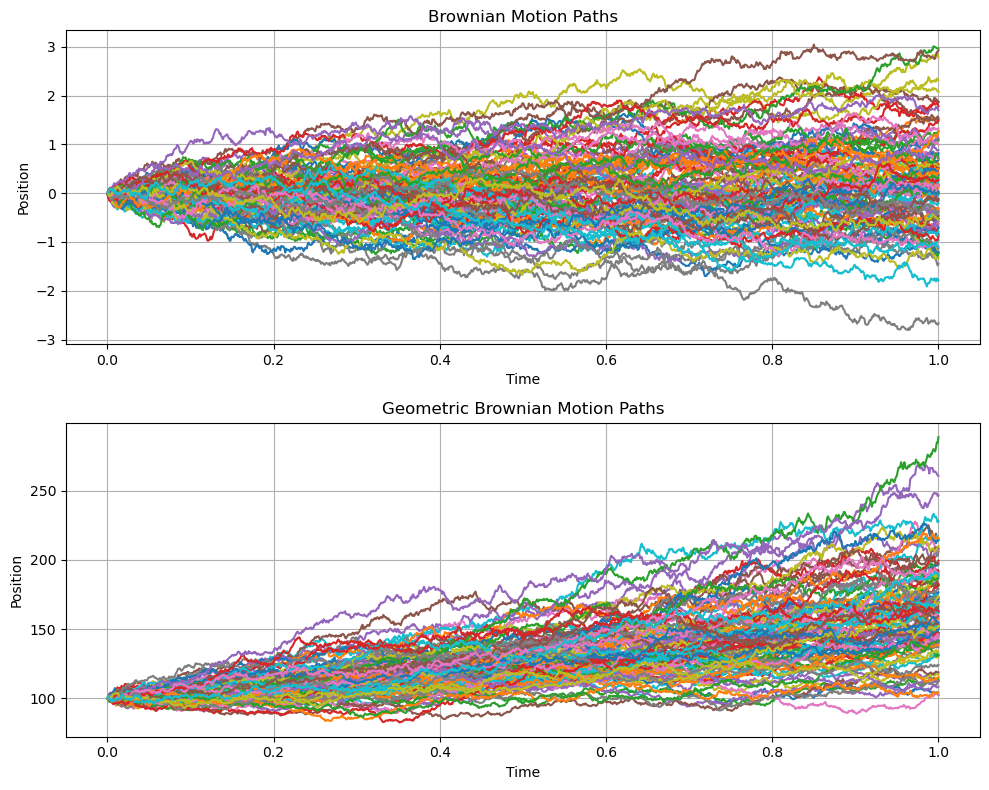

In [30]:
brownian_motion = Brownian_Motion(
    T = 1,
    sample_size = 100
)

geometric_brownian_motion = Geometric_Brownian_Motion(
    S0 = 100,
    T = 1,
    sigma = 0.2,
    r = 0.5,
    sample_size = 100
)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

path_bm = brownian_motion.Brownian_Path()
time_points_bm = np.linspace(0, brownian_motion.T, brownian_motion.time_grid + 1)
for i in range(brownian_motion.sample_size):
    axes[0].plot(time_points_bm, path_bm[i], label = f'Path {i + 1}' if brownian_motion.sample_size <= 5 else None)
axes[0].set_title('Brownian Motion Paths')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Position')
axes[0].grid(True)
if brownian_motion.sample_size <= 5:
    axes[0].legend()

path_gbm = geometric_brownian_motion.Geometric_Brownian_Path()
time_points_gbm = np.linspace(0, geometric_brownian_motion.T, geometric_brownian_motion.time_grid + 1)
for i in range(geometric_brownian_motion.sample_size):
    axes[1].plot(time_points_gbm, path_gbm[i], label = f'Path {i + 1}' if geometric_brownian_motion.sample_size <= 5 else None)
axes[1].set_title('Geometric Brownian Motion Paths')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Position')
axes[1].grid(True)
if geometric_brownian_motion.sample_size <= 5:
    axes[1].legend()
plt.tight_layout()
plt.show()

### Asian Option Class

This class simulates and prices **Asian options** using Monte Carlo methods. An Asian option is a type of exotic option where the payoff depends on the average price of the underlying asset over a certain period rather than its price at maturity. This averaging reduces volatility and makes Asian options popular in markets with volatile assets.

#### Attributes:
- **S0**: Initial stock price.
- **K**: Strike price of the option.
- **T**: Time to maturity (in years).
- **sigma**: Volatility of the underlying asset.
- **r**: Risk-free interest rate.
- **option_type**: Type of the option, either "call" or "put".
- **sample_size**: *(Optional)* Number of Monte Carlo paths (default is 10,000).
- **confidence_level**: *(Optional)* Confidence level for error estimation (default is 0.95).
- **time_grid**: *(Optional)* Number of discrete time points for path simulation (default is 1,000).
- **integration_method**: *(Optional)* Method for averaging the path, either "Riemann", "Trapezoid", or "Simpson" (default is "Simpson").

#### Methods:
1. **`Path()`**:
   - Simulates paths of the underlying asset using the Geometric Brownian Motion model.
   - Steps:
     - Generates normal random variables for the increments.
     - Computes the logarithmic increments:
       $$
       \text{log\_increments} = \left(r - \frac{\sigma^2}{2}\right) \frac{T}{\text{time\_grid}} + \sigma \sqrt{\frac{T}{\text{time\_grid}}} \cdot G
       $$
     - Cumulatively sums the increments to create the log-path.
     - Converts the log-path to the price path using the exponential function.

2. **`Riemann_Integral()`**:
   - Approximates the average price of the underlying asset using the Riemann sum:
     $$
     \text{Average Price} = \frac{1}{\text{time\_grid}} \sum_{i=1}^{\text{time\_grid}} S_t
     $$
   - This is a simple approximation of the integral.

3. **`Trapezoidal_Integral()`**:
   - Approximates the average price using the trapezoidal rule:
     $$
     \text{Average Price} = \frac{T}{\text{time\_grid}} \left(\frac{S_0 + S_T}{2} + \sum_{i=1}^{\text{time\_grid} - 1} S_t\right)
     $$
   - Provides a more accurate approximation than the Riemann sum.

4. **`Simpson_Integral()`**:
   - Approximates the average price using Simpson's rule:
     $$
     \text{Average Price} = \frac{\Delta t}{3} \left(S_0 + 4 \sum_{\text{odd } i} S_t + 2 \sum_{\text{even } i} S_t + S_T\right)
     $$
   - This is the most accurate integration method for smooth paths.

5. **`Monte_Carlo_Price()`**:
   - Prices the Asian option using Monte Carlo simulation:
     - Computes the average price of the underlying using the specified integration method ("Riemann", "Trapezoid", or "Simpson").
     - Calculates the discounted payoff for each path:
       - **Call Option**: $\max(\text{Average Price} - K, 0)$
       - **Put Option**: $\max(K - \text{Average Price}, 0)$
     - Averages the payoffs to estimate the option price.
     - Computes the standard error and confidence interval.

#### Observations:
- **Path Simulation**:
  - The paths of the underlying asset follow a Geometric Brownian Motion process, ensuring consistency with financial models.
- **Integration Methods**:
  - Riemann sum is the simplest but least accurate.
  - Trapezoidal and Simpson’s rules provide more accurate approximations of the average price.
- **Monte Carlo Pricing**:
  - Uses simulated paths and the averaging method to estimate the price and quantify uncertainty via confidence intervals.

#### Key Takeaways:
- This class provides a flexible framework for pricing Asian options using Monte Carlo simulations.
- The integration methods allow for different levels of accuracy in averaging the underlying price.
- Confidence intervals and errors offer insight into the reliability of the Monte Carlo estimates.

In [32]:
class Asian_Option:
    def __init__(self, S0, K, T, sigma, r, option_type, sample_size = 10000, confidence_level = 0.95, time_grid = 1000, integration_method = "Simpson"):
        self.S0 = S0
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.option_type = option_type
        self.sample_size = sample_size
        self.confidence_level = confidence_level
        self.time_grid = time_grid
        self.integration_method = integration_method

    def Path(self):
        G = npr.normal(0, 1, size = (self.sample_size, self.time_grid))
        log_increments = (self.r - 0.5 * self.sigma**2) * (self.T / self.time_grid) + self.sigma * np.sqrt(self.T / self.time_grid) * G
        log_increments = np.concatenate((np.log(self.S0) * np.ones((self.sample_size, 1)), log_increments), axis = 1)
        log_path = np.cumsum(log_increments, axis = 1)
        path = np.exp(log_path)

        return path

    def Riemann_Integral(self):
        path = self.Path()
        integral = np.mean(path, axis = 1) 

        return integral

    def Trapezoidal_Integral(self):
        path = self.Path()
        integral = (self.T / self.time_grid) * (((path[:, 0] + path[:, -1]) / 2) + np.sum(path[:, 1:-1], axis = 1))

        return integral

    def Simpson_Integral(self):
        path = self.Path()
        integral = ((self.T / self.time_grid) / 3) * (path[:, 0] + 4 * np.sum(path[:, 1:-1:2], axis = 1) + 2 * np.sum(path[:, 2:-1:2], axis = 1) + path[:, -1])
        
        return integral

    def Monte_Carlo_Price(self):
        if self.integration_method == "Riemann":
            integral = self.Riemann_Integral()
        elif self.integration_method == "Trapezoid":
            integral = self.Trapezoid_Integral()
        elif self.integration_method == "Simpson":
            integral = self.Simpson_Integral()
        else:
            raise ValueError("Invalid Integration Method: it must be 'Riemann', 'Trapezoid' or 'Simpson'")

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(integral - self.K, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        elif self.option_type == "put":                
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - integral, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

In [33]:
asian_option = Asian_Option(
    S0 = 100,               # Spot price of 100
    K = 100,                # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call"    # Option Type
)

mc_price, mc_confidence_interval, mc_error = asian_option.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{mc_confidence_interval[0]:.5f}, {mc_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {mc_error:.5f}")

Monte Carlo Option Price: 5.77162
95% Confidence Interval: [5.61569, 5.92755]
Monte Carlo Error: 0.15593


### Barrier Option Class

This class simulates and prices **Barrier Options** using Monte Carlo methods. Barrier options are exotic options whose payoff depends on whether the underlying asset's price crosses a specified barrier during its lifetime. Specifically, this implementation handles **up-and-out barrier options**, where the option becomes worthless if the asset price crosses the barrier.

#### Attributes:
- **S0**: Initial stock price.
- **K**: Strike price of the option.
- **T**: Time to maturity (in years).
- **sigma**: Volatility of the underlying asset.
- **r**: Risk-free interest rate.
- **option_type**: Type of the option, either "call" or "put".
- **barrier**: The barrier level that determines whether the option becomes worthless.
- **sample_size**: *(Optional)* Number of Monte Carlo paths (default is 10,000).
- **confidence_level**: *(Optional)* Confidence level for error estimation (default is 0.95).
- **time_grid**: *(Optional)* Number of discrete time points for path simulation (default is 1,000).

#### Methods:
1. **`Path()`**:
   - Simulates paths of the underlying asset using the Geometric Brownian Motion model.
   - Steps:
     - Generates normal random variables for the increments.
     - Computes the logarithmic increments:
       $$
       \text{log\_increments} = \left(r - \frac{\sigma^2}{2}\right) \frac{T}{\text{time\_grid}} + \sigma \sqrt{\frac{T}{\text{time\_grid}}} \cdot G
       $$
     - Cumulatively sums the increments to create the log-path.
     - Converts the log-path to the price path using the exponential function.
   - Returns a matrix of shape `(sample_size, time_grid + 1)`, where each row represents a simulated path.

2. **`Monte_Carlo_Price()`**:
   - Prices the barrier option using Monte Carlo simulation:
     - Simulates paths of the underlying asset.
     - Computes the maximum price for each path:
       $$
       \text{max\_path} = \max(S_t \text{ for } t \in [0, T])
       $$
     - Applies the barrier condition:
       - If $\text{max\_path} > \text{barrier}$, the payoff is calculated.
       - Otherwise, the payoff is set to zero (the option is knocked out).
     - For a **call option**, the payoff is:
       $$
       \max(S_T - K, 0) \cdot \mathbb{1}(\text{max\_path} > \text{barrier})
       $$
     - For a **put option**, the payoff is:
       $$
       \max(K - S_T, 0) \cdot \mathbb{1}(\text{max\_path} > \text{barrier})
       $$
     - Discounts the payoff to the present value:
       $$
       \text{payoff} = e^{-rT} \cdot \text{payoff}
       $$
     - Computes the option price as the average payoff.
     - Calculates the standard deviation, Monte Carlo error, and confidence interval.

#### Outputs:
- **Price**: The estimated price of the barrier option.
- **Confidence Interval**: The range within which the true option price lies, with the specified confidence level.
- **Error**: The Monte Carlo standard error for the estimated price.

#### Observations:
- **Path Simulation**:
  - The paths follow a Geometric Brownian Motion model, ensuring the consistency of the asset price dynamics.
- **Barrier Condition**:
  - The barrier condition is checked by evaluating whether the maximum price along the path exceeds the specified barrier level.
- **Monte Carlo Pricing**:
  - Monte Carlo simulation provides an accurate estimate of the barrier option price, along with uncertainty quantification through the confidence interval and error.

#### Key Takeaways:
- This class provides a robust framework for pricing barrier options using Monte Carlo methods.
- The `Path()` method simulates the asset price dynamics, while the `Monte_Carlo_Price()` method incorporates the barrier condition to calculate the payoff.
- Confidence intervals and errors offer insights into the reliability of the price estimate, making the method suitable for practical applications.

In [35]:
class Barrier_Option:
    def __init__(self, S0, K, T, sigma, r, option_type, barrier, sample_size = 10000, confidence_level = 0.95, time_grid = 1000):
        self.S0 = S0
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.option_type = option_type
        self.barrier = barrier
        self.sample_size = sample_size
        self.confidence_level = confidence_level
        self.time_grid = time_grid

    def Path(self):
        G = npr.normal(0, 1, size = (self.sample_size, self.time_grid))
        log_increments = (self.r - 0.5 * self.sigma**2) * (self.T / self.time_grid) + self.sigma * np.sqrt(self.T / self.time_grid) * G
        log_increments = np.concatenate((np.log(self.S0) * np.ones((self.sample_size, 1)), log_increments), axis = 1)
        log_path = np.cumsum(log_increments, axis = 1)
        path = np.exp(log_path)

        return path
        
    def Monte_Carlo_Price(self):
        path = self.Path()
        max_path = np.max(path, axis = 1)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(path[:, -1] - self.K, 0) * (max_path > self.barrier)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - path[:, -1], 0) * (max_path > self.barrier)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf((self.confidence_level + 1) / 2) * standard_deviation / np.sqrt(self.sample_size)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval, error

In [36]:
barrier_option = Barrier_Option(
    S0 = 100,               # Spot price of 100
    K = 100,                # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call",   # Option Type
    barrier = 90            # Barrier
)

mc_price, mc_confidence_interval, mc_error = barrier_option.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.5f}")
print(f"{european_option.confidence_level * 100:.0f}% Confidence Interval: [{mc_confidence_interval[0]:.5f}, {mc_confidence_interval[1]:.5f}]")
print(f"Monte Carlo Error: {mc_error:.5f}")

Monte Carlo Option Price: 10.32589
95% Confidence Interval: [10.04033, 10.61144]
Monte Carlo Error: 0.28555
